In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io
import scipy.signal
import time
from noise_buffer_overlay import NoiseOverlay
from datetime import datetime

In [2]:
ol = NoiseOverlay(bitfile_name='hw/top_biastini_noise_buffer_corrected_fp.bit',download=True,dbg=True,plot=False)

loading bitfile hw/top_biastini_noise_buffer_corrected_fp.bit


loaded bitstream
set clocks


In [3]:
ol.set_dac_scale_factor(0,0)
ol.set_dac_scale_factor(0,1)
ol.set_vga_atten_dB(0,0)
ol.set_vga_atten_dB(0,1)
# to keep full scale, multiply by 0.5, but we can always adjust to improve dynamic range
ol.set_adc_digital_gain(1,0)
ol.set_adc_digital_gain(1,1)

setting dac_prescale scale_factor to 0.0 (00000)
setting dac_prescale scale_factor to 0.0 (00000)
setting vga attenuation to 0dB
packet = 0x200
setting vga attenuation to 0dB
packet = 0x10200
setting adc_gain scale_factor to 1.0 (10000)
setting adc_gain scale_factor to 1.0 (10000)


In [123]:
# configure noise buffer and capture some data
ol.set_discriminator_threshold(0.005*32)
ol.start_capture()
time.sleep(10)
ol.stop_capture()
time.sleep(0.1)
ol.dma()

setting discriminator thresholds 0.16-0.16
packet = ['0x1470147', '0x0']
sending start command with discriminator thresholds 327:327
packet = ['0x1470147', '0x2']
sending stop command with discriminator thresholds 327:327
packet = ['0x1470147', '0x1']


In [135]:
# process data to separate out channels and timestamp vs sample data
# first check to see if we have any full timestamps
# if we do, throw out all data until the sample before the first timestamp for each channel (since we don't know when it occurred)
# if we don't, proceed
ch = [np.take(ol.dma_buffer, np.asarray(ol.dma_buffer & 1 == i).nonzero()[0]) for i in range(2)]
data = []
tvec = []
timestamps = []
for c in ch:
    print(f' processing channel')
    # find the number of timestamps
    n_timestamps = np.asarray(c & 2 == 2).nonzero()[0]
    valid_timestamp = False
    n_0 = 0
    print(f'n_timestamps = {n_timestamps[:30]}')
    print(f'raw channel data = {[hex(i) for i in c[:40]]}')
    if len(n_timestamps) >= 4:
        # find first valid timestamp
        while True:
            if n_0 + 3 > len(n_timestamps) - 1:
                break
            if (n_timestamps[n_0+3] == n_timestamps[n_0]+3):
                # since n_timestamps is strictly increasing and takes on integer values,
                # n_timestamps[n_0+3] == n_timestamps[n_0]+3 is equivalent to n_timestamps[n_0:n_0+4] = [i, i+1, i+2, i+3] for some i
                valid_timestamp = True
                break
            n_0 += 1
        # check for errors
        n = n_0
        err_count = 0
        while True:
            if n + 3 > len(n_timestamps) - 1:
                break
            error = False
            for i in range(4):
                if n_timestamps[n+i] != n_timestamps[n] + i:
                    error = True
            if error and err_count < 10:
                print(f'bad timestamp near raw channel data index {n_timestamps[n:n+4]}')
                err_count += 1
            if err_count == 10:
                print(f'additional errors suppressed')
                err_count += 1
            n += 4
            
    print(f"raw channel data = {[(hex(x >> 2),'t',n+58620) if x & 2 == 2 else (hex(x >> 3),'s',n+58620) for n,x in enumerate(c[58620:58640])]}")
    # now n_timestamps[n_0] holds the index into c for the first valid timestamp
    # extract the data
    if (n_timestamps[n_0] == 0) or (not valid_timestamp):
        # just ignore the existence of timestamps; we have a contiguous block of data
        data.append(np.take(np.right_shift(c.astype(np.int16), 3)/2**13, np.asarray(c & 2 == 0).nonzero()[0]))
    else:
        # n_timestamps[n_0] > 0 and we have a valid timestamp
        # trim all data up to the point before the first timestsamp
        data.append(np.take(np.right_shift(c[n_timestamps[n_0]-1:].astype(np.int16), 3)/2**13, np.asarray(c[n_timestamps[n_0]-1:] & 2 == 0).nonzero()[0]))
    # by default, no need to do anything fancy if we have no timestamps: we assume all data is consecutive
            
    if not valid_timestamp:
        timestamps.append(np.array([], dtype=np.float64))
        tvec.append(np.arange(data[-1].shape[0], dtype=np.float64))
    else:
        tvec_raw = np.zeros(c.shape[0], dtype=np.float64)
        # update tvec with timestamp info
        # now extrapolate between the supplied timestamps to get the timestamp for each data point
        # index into original raw channel data for datapoints which should have a tvec update:
        n_t_update = n_timestamps[n_0::4] - 1
        raw_timestamp_words = np.take(np.right_shift(c.astype(np.uint16), 2), n_timestamps[n_0:])
        raw_timestamp_words_grouped = raw_timestamp_words[:4*(len(raw_timestamp_words) // 4)].reshape((len(raw_timestamp_words)//4,4))
        concat_timestamps = np.inner(raw_timestamp_words_grouped, 2**(14*np.arange(4, dtype=np.uint64)))
        timestamps.append(concat_timestamps)
        t_0 = timestamps[-1][0]
        print(f'type(t_0) = {type(t_0)}')
        print(f'raw_timestamp_words_grouped = {np.array2string(raw_timestamp_words_grouped, formatter={"int":lambda x: hex(x)})}')
        print(f'timestamps[-1][0] = {hex(timestamps[-1][0])}')
        print(f'timestamps[-1][-1] = {hex(timestamps[-1][-1])}')
        print(f'type(timestamps[-1][-1]) = {type(timestamps[-1][-1])}')
        #for i, timestamp in enumerate(timestamps):
        print(f'n_t_update = {n_t_update[:20]}')
        print(f'timestamps = {timestamps[-1][:20] - t_0}')
        for n in range(len(n_t_update)-1):
            # if n_0 == 0, then n_t_update will contain -1 for the first iteration
            lower = n_t_update[n] if n_0 >= 0 else 4
            # subtract extra 4 to offset for the timestamp samples
            tvec_raw[lower:n_t_update[n+1]] = timestamps[-1][n] - t_0 - np.float128(4) + np.arange(n_t_update[n+1] - n_t_update[n], dtype=np.float128)
            if n_0 >= 0:
                # we need to correct the first element, since it is 4 too small
                tvec_raw[lower] = timestamps[-1][n] - t_0
        # update the end of the vector
        tvec_raw[n_t_update[-1]:] = timestamps[-1][-1] - t_0 - 4 + np.arange(len(tvec_raw)-n_t_update[-1], dtype=np.float128)
        tvec_raw[n_t_update[-1]] = timestamps[-1][-1] - t_0
        # take only valid entries
        tvec.append(np.take(tvec_raw[n_timestamps[n_0]-1:], np.asarray(c[n_timestamps[n_0]-1:] & 2 == 0).nonzero()[0]))
        print(f'tvec = {tvec[-1][:20]}')

 processing channel
n_timestamps = [ 0  1  2  3  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27 28
 30 31 32 33 35 36]
raw channel data = ['0x57b6', '0xb682', '0xc12', '0x2', '0x19c', '0xbdd2', '0xb686', '0xc12', '0x2', '0x14c', '0xf916', '0xb686', '0xc12', '0x2', '0x14c', '0x47a2', '0xb696', '0xc12', '0x2', '0x15c', '0x5ab2', '0xb69e', '0xc12', '0x2', '0x184', '0x2b26', '0xb6aa', '0xc12', '0x2', '0x154', '0x4b02', '0xb6b2', '0xc12', '0x2', '0x16c', '0x5ad6', '0xb6b2', '0xc12', '0x2', '0x15c']
bad timestamp near raw channel data index [58631 58632 58633 58635]
bad timestamp near raw channel data index [58636 58637 58638 58640]
bad timestamp near raw channel data index [58641 58642 58643 58645]
bad timestamp near raw channel data index [58646 58647 58648 58650]
bad timestamp near raw channel data index [58651 58652 58653 58656]
bad timestamp near raw channel data index [58657 58658 58659 58661]
bad timestamp near raw channel data index [58662 58663 58664 58666]
bad timestamp ne

ValueError: could not broadcast input array from shape (5,) into shape (0,)

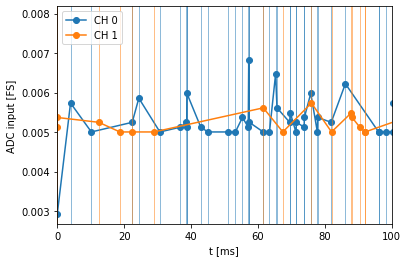

In [85]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for c in range(2):
    plt.plot(tvec[c][:500]/32e3, data[c][:500], 'o-', label=f'CH {c}')
    for thi in timestamps[c][:100] - timestamps[c][0]:
        plt.axvline(x=thi/32e3, linewidth=0.5, color=colors[c])
#plt.ylim(-0.1, 0.6)
plt.xlim(-0.1, 100)
#plt.xlim(5.8, 7)
plt.xlabel("t [ms]")
plt.ylabel("ADC input [FS]")
plt.legend()

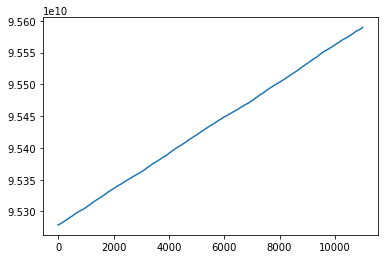

In [122]:
plt.plot(timestamps[0][:11000])